###### Convolutional Neural Networks
From previous lecture, we successfully classified image data using only flattening. However, when we consider more complex and "unstandardized" images, flattening approach will not succeed, because the object that determines the class of the image can be positioned various locations and various lighting conditions. In order to overcome this issue, we shall inspect the relationship between the pixels insted of sequential values. 
<br><br>
We will use the dataset below in this example. <br>
https://www.kaggle.com/chetankv/dogs-cats-images

## Convolution Layers
Kernels are filters that extracts the relationship between adjacent pixels. For a detailed demonstration and explanation you can visit: <br> https://setosa.io/ev/image-kernels/ <br>
Convolution layers are the processors that cover given inputs with kernels, and create output layers.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils
import cv2


import numpy as np

from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
os.getcwd()

Using cpu device


'/Users/sonerkuyar/Desktop/OneDrive - boun.edu.tr/Belgeler/GitHub/level-2-Soner-Kuyar/Tasks/Task2-ConvolutionalNN-AnimalRecognition'

**Loading the image**

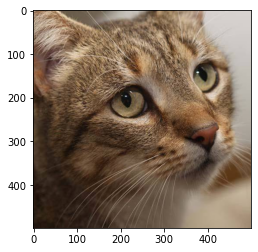

(499, 500, 3)


In [2]:
# Load image to the memory
image = cv2.imread(r'dataset/training_set/cats/cat.54.jpg')

# As cv2 library loads image in BGR color schema, we need to convert it to RGB in order to visualize in matplotlib.
# If you use cv2.imshow() method you do not do that step. However, that method results Jupyter to crash.

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Show image
plt.imshow(image)
plt.show()

print(image.shape)

**Applying Convolution**

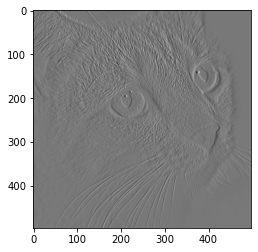

(497, 498, 1)


In [3]:
# Get how many channels image contains, in this case 3 -> R(ed) G(reen) B(lue)
nb_channels = image.shape[2]
output_channels = 1

# Convert image from NumPy/CV2 to Torch Tensor.
# As a side note, in Torch Tensors data is structured as
# (BatchSize, ChannelSize, YSize, XSize)
# Whereas, in CV2/NumPy data is is structured as
# (BatchSize, YSize, XSize)
# So we need to change the dimension of the data either using .transpose() method
# in NumPy or .permute() method in Torch.

image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2,0,1)

# For the purpose of demonstration we define our own kernel weights
# However, they are assigned randomly for training purposes. So you will
# not have to repeat this step when training a neural network.

weights = torch.tensor([[-1., 0., 1.],
                        [-1., 0., 1.],
                        [-1., 0., 1.]])
weights = weights.view(1,1, 3, 3).repeat(output_channels,nb_channels, 1, 1)

# We 'forward' the input to get the output of the convolution process.

output = F.conv2d(image_tensor.unsqueeze_(0), weights)
output_image = output[0].permute(1, 2, 0).numpy()

plt.imshow(output_image, cmap='binary')
plt.show()

print(output_image.shape)

You can observe that size of the image decreases by 2 pixel from both dimensions. It is because convolution takes the middle point of the kernel as the output pixel. As the kernel has dimensions of 3x3 the edge pixels can not be included in the output.
<br>
Output dimensions can be adjusted using **stride and padding**. For further reading you can utilize the source below: <br>
https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529

### Exercise 1
Apply "outline" kernel filter to the image above

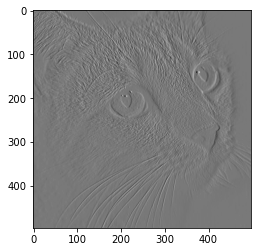

(497, 498, 1)


In [4]:
image_tensor = torch.from_numpy(image.astype(np.float32)).permute(2,0,1)
weights = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]])
weights = weights.view(1,1, 3, 3).repeat(output_channels,nb_channels, 1, 1)
output = F.conv2d(image_tensor.unsqueeze_(0), weights)
output_image = output[0].permute(1, 2, 0).numpy()

plt.imshow(output_image, cmap='binary')
plt.show()

print(output_image.shape)


## Data Loaders
Image files are big. In jpeg format they are compressed. Even their compressed sizes are a lot larger than a numeric dataset. When they are imported and transferred to the memory, their sizes increase more, making it impossible to process even medium sized datasets at a personal computer. For that case, we use data loaders, which carry just enough samples from a dataset and use them for an iteration.
### Exercise 2
Fill 2 blanks given in the \_\_getitem\_\_ method.

In [5]:
class CatDogDataset(Dataset):
    def __init__(self, input_size = (128,128), training=True):
        # Define the image size that will be inputted to the model.
        self.input_size = input_size
        
        # Create a transformer that converts image array to tensor.
        self.transform = transforms.Compose([transforms.ToTensor()])
        
        # Define if the dataset object is created for training or test.
        # Define data path.
        if training:
            path = r'dataset/training_set'
        else:
            path = r'dataset/test_set'
        print(path)
            
        # Extract categories if the folder.
        # Create a data variable which is in the format of [[FilePath, FileClass/Index] ... [...]]
        self.classes = os.listdir(path)
        files = []
        labels = np.zeros((0,1))
        for cls in self.classes:
            if cls == '.DS_Store':
                break
            new_files = [path + '/' + cls + '/' + x for x in os.listdir(path + '/' + cls)]
            files.extend(new_files)
            new_labels = np.full((len(new_files),1),self.classes.index(cls))
            labels = np.vstack((labels,new_labels))
        self.data = np.hstack((np.array(files).reshape(-1,1),labels))
        
        # Shuffle the data.
        np.random.shuffle(self.data)

    # len method returns the lenghts of the dataset. It is the value when len(obj) is called.
    def __len__(self):
        return self.data.shape[0]
    
    # getitem method extracts data for each datapoint. It is the vale when the object is
    # inserted in a for loop.
    def __getitem__(self, idx):
        # Read image from file. Adding 0 as the second parameter makes image imported
        # in grayscale format. (Black and white)
        image = cv2.imread(self.data[idx,0],0)
        
        # Resize the image for the model.
        image = cv2.resize(image,(128,128))
        
        # Read the label for the image.
        label = self.data[idx,1]
        
        # Convert label data to long as loss function expects long.
        label = np.array(label.astype(np.float32), dtype=np.long)
        return self.transform(image).to(device), torch.from_numpy(label).to(device).long()

# Define datasets and generators.
training_data = CatDogDataset()
test_data = CatDogDataset(training=False)

training_generator = DataLoader(training_data, batch_size=16)
test_generator = DataLoader(test_data, batch_size=16)

dataset/training_set
dataset/test_set


## Defining Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, (5,5)) # Input Channels, Output Channels, Kernel Size
        self.pool = nn.MaxPool2d((2, 2)) # Kernel Size
        self.conv2 = nn.Conv2d(5, 20, (5,5))
        self.fc1 = nn.Linear(20 * 29 * 29, 32) #128->124->62->58->29
        self.fc2 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Exercise 3
Explain why we used dropout layers and how they work.

 <font color='red'>Deeper the neural network, more tendency to overfit. So, dropping layers randomly out provide our model to overfit. If we choose big ratio (ex. 0.99) our system will do underfiting so Dropout ratio also have to be optimized. When we choose proper ratio for dropout our model will be more regularized. </font> 

## Training
### Exercise 4
Decide on the epoch number of the training. Explain why you chose that number.

In [10]:
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
epochs = 5 #10

for epoch in range(epochs):
    net.train()
    loss_sum = 0
    for i, (img, label) in enumerate(training_generator):
        img = img
        label = label
        optimizer.zero_grad()
        #
        outputs = net(img)
        loss = criterion(outputs, label)
        # backward and opitimize
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/(i+1):.4f}\t({100*(i+1)/len(training_generator):.0f}%)", end='\r')
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_generator):
            img = img
            label = label
            outputs = net(img)
            loss = criterion(outputs, label)
            valid_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/len(training_generator):.4f}\tValidation Loss:{valid_loss/len(test_generator):.4f}")

Epoch 1/5	Loss:0.6673	Validation Loss:0.6352
Epoch 2/5	Loss:0.5941	Validation Loss:0.5877
Epoch 3/5	Loss:0.5185	Validation Loss:0.5733
Epoch 4/5	Loss:0.4547	Validation Loss:0.6068
Epoch 5/5	Loss:0.3925	Validation Loss:0.6382


# I decide to choose 5 epoch due to increasing in validation loss after 4-5

## Evaluate the Model
### Exercise 5
Calculate the accuracy of the model on the test data.

In [11]:
classes ={1: 'cat',0: 'dog'}
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_generator:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(16):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 69.55 %
Accuracy of dog: 85.0 %
Accuracy of cat: 54.1 %


### Exercise 6
Show some sample images and their predictions from the test data.

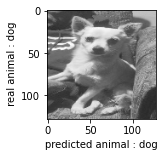

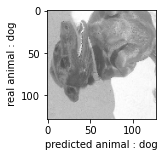

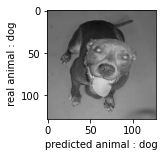

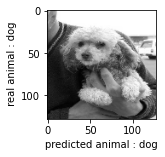

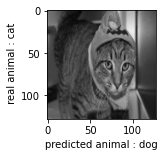

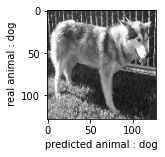

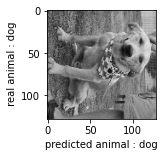

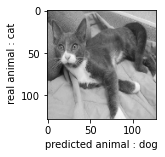

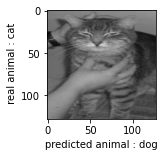

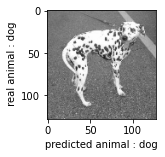

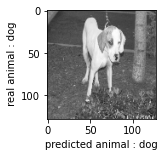

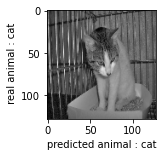

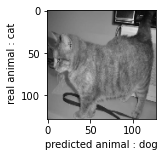

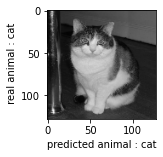

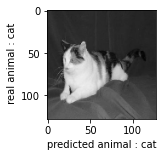

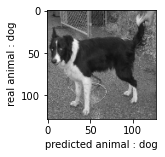

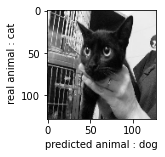

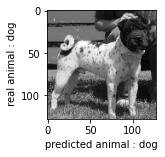

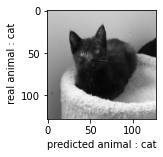

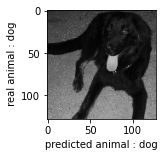

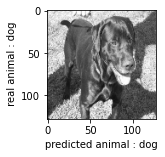

In [18]:
#take the random image from each batch (thats a kind of rondomness)
import random as rd
net.eval()
def plot_sample(img,pred,label):
    plt.figure(figsize = (15,2))
    plt.imshow(img)
    plt.xlabel("predicted animal : " + classes[pred])
    plt.ylabel(" real animal : " + classes[label] )
    

for i,(img,labels) in enumerate(test_generator):
    num = rd.randint(0,15)
    
    outputs = net(img)
    _, predicted = torch.max(outputs, 1)
    pred = predicted[num]
    #there is batch_size image in each loop so ve should take the particular one
    img = img[num].permute(1,2,0).numpy()
    #img should be converted BGR to RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #to indexing variables should convert to integer
    pred = np.int_(pred.numpy())
    label = labels[num]
    label = np.int_(label.numpy())
    
    
    
    plot_sample(img,pred,label)
    if i==20:
        break
        
        
    
    
    

## Your Turn
Using the dataset below:
1. Split the dataset into train and test sets.
2. Design a classifier.
3. Evaluate the classifier on the test set.
<br>

https://www.kaggle.com/piyushkumar18/animal-image-classification-dataset